# Reannotation of pigment cells

In our smart-seq3, although we know our pigment cells mainly express gch2 gene, we still need to annotate the actual gch2+ pigment cells to make sure our evaluated cell state align to the cell state in perturb-seq. Therefore, we could integrate the pigment cell population in perturb-seq and smart-seq3, and transfer perturb-seq label on smart-seq3 dataset.

## Library imports

In [1]:
import cellrank as cr
import scvelo as scv
import scanpy as sc
import scanpy.external as sce

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import faiss
from collections import Counter

import scipy
import numpy as np
import pandas as pd

from rgv_tools import DATA_DIR, FIG_DIR

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regve

## General setting

In [2]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [3]:
DATASET = "zebrafish"

In [4]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

## Data loading

Note: The perturb-seq datasets will be released after the paper is officially online. Users can access them via `regvelo.datasets.zebrafish_perturb`.

In [5]:
perturb_seq = sc.read_h5ad(DATA_DIR / DATASET / "raw" / "perturbseq_all.h5ad")
ss3 = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

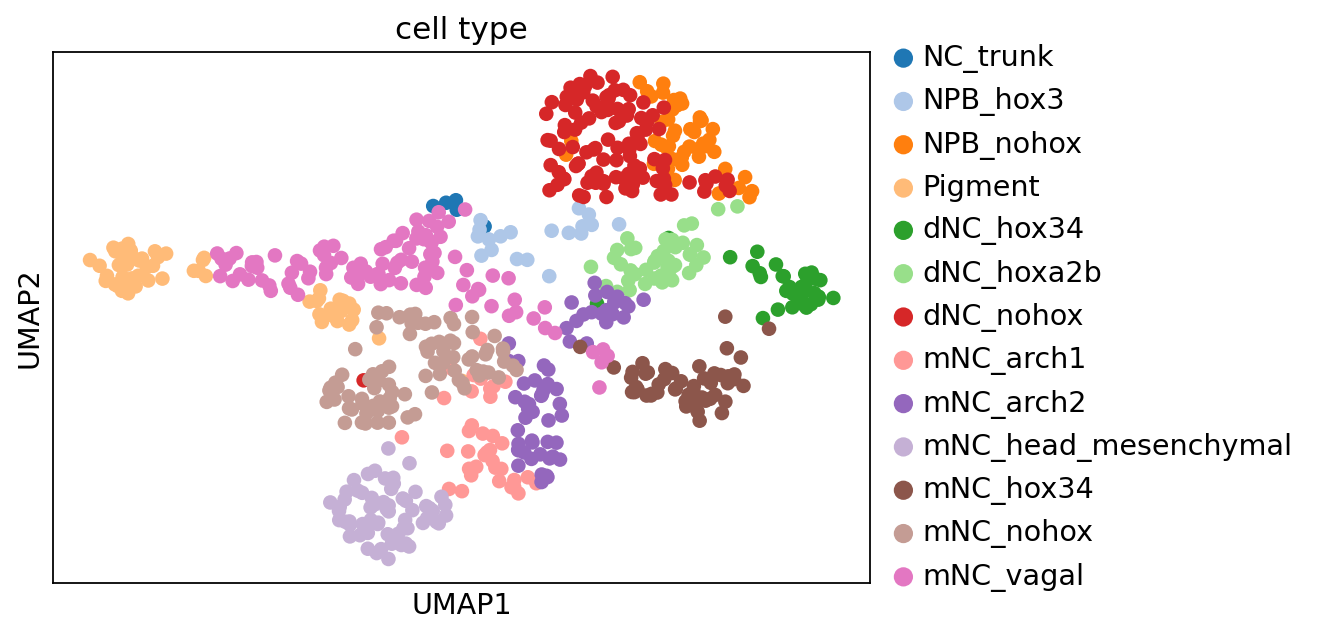

In [6]:
sc.pl.scatter(ss3,basis = "umap",color = "cell_type")

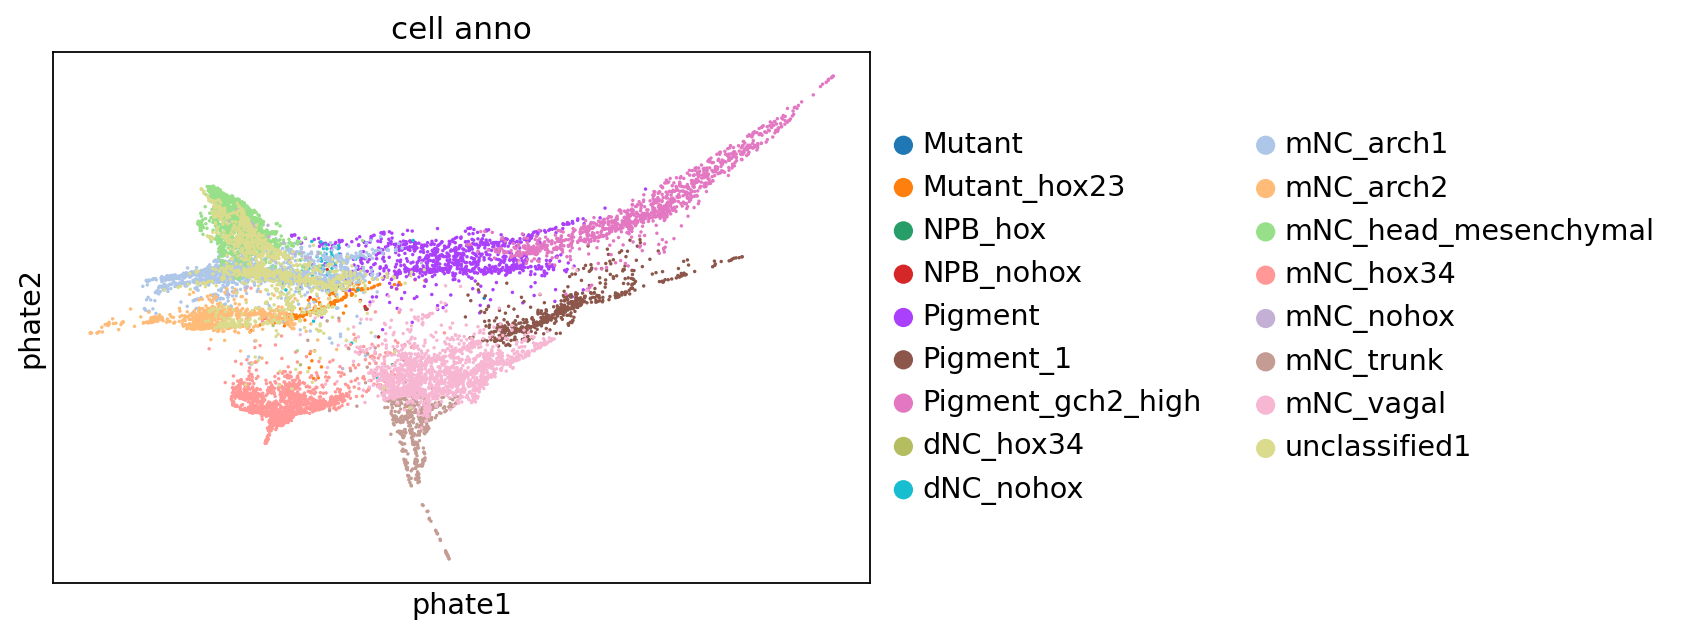

In [7]:
sc.pl.scatter(perturb_seq,basis = "phate",color = "cell_anno")

## Integrate ss3 and perturb seq dataset

In [8]:
ss3_p = ss3[ss3.obs["cell_type"] == "Pigment"]

In [9]:
ref_p = perturb_seq[perturb_seq.obs["sgRNA_group"] == "control"].copy()
ref_p = ref_p[ref_p.obs["cell_anno"].isin(["Pigment","Pigment_gch2_high"])].copy()

In [10]:
sc.pp.scale(ref_p)
sc.pp.scale(ss3_p)

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
gene = list(set(ss3_p.var_names).intersection(ref_p.var_names))

merged_adata = ref_p[:,gene].concatenate(ss3_p[:,gene], batch_key='batch')

In [12]:
sc.tl.pca(merged_adata)

In [13]:
sce.pp.harmony_integrate(merged_adata, "batch")

2025-08-28 16:46:47,452 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-28 16:46:48,060 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-28 16:46:48,068 - harmonypy - INFO - Iteration 1 of 10
2025-08-28 16:46:48,114 - harmonypy - INFO - Iteration 2 of 10
2025-08-28 16:46:48,135 - harmonypy - INFO - Iteration 3 of 10
2025-08-28 16:46:48,146 - harmonypy - INFO - Iteration 4 of 10
2025-08-28 16:46:48,156 - harmonypy - INFO - Iteration 5 of 10
2025-08-28 16:46:48,165 - harmonypy - INFO - Converged after 5 iterations


In [14]:
sc.pp.neighbors(merged_adata,n_pcs = 30,use_rep = "X_pca_harmony")

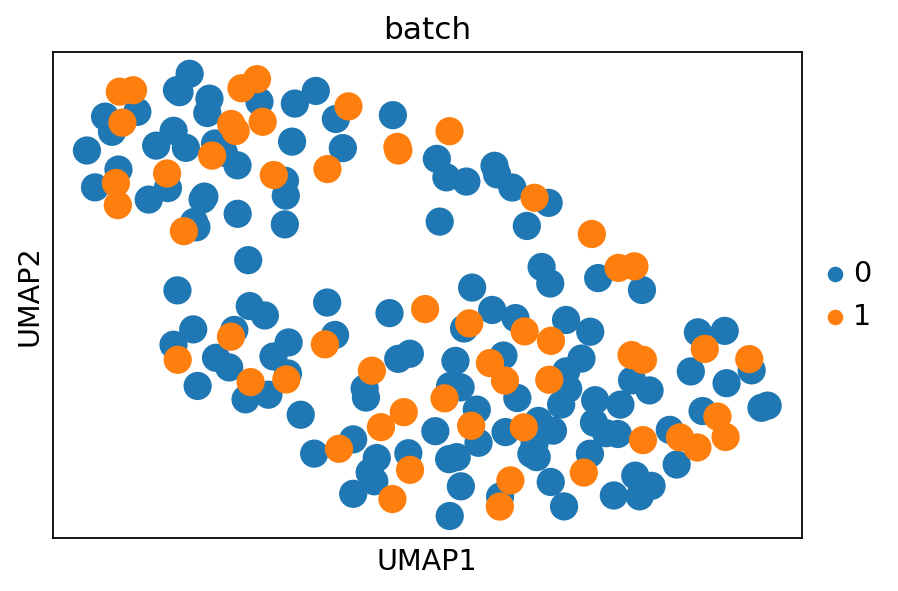

In [15]:
sc.tl.umap(merged_adata)
sc.pl.umap(
    merged_adata,
    color="batch",
    # Setting a smaller point size to get prevent overlap
)

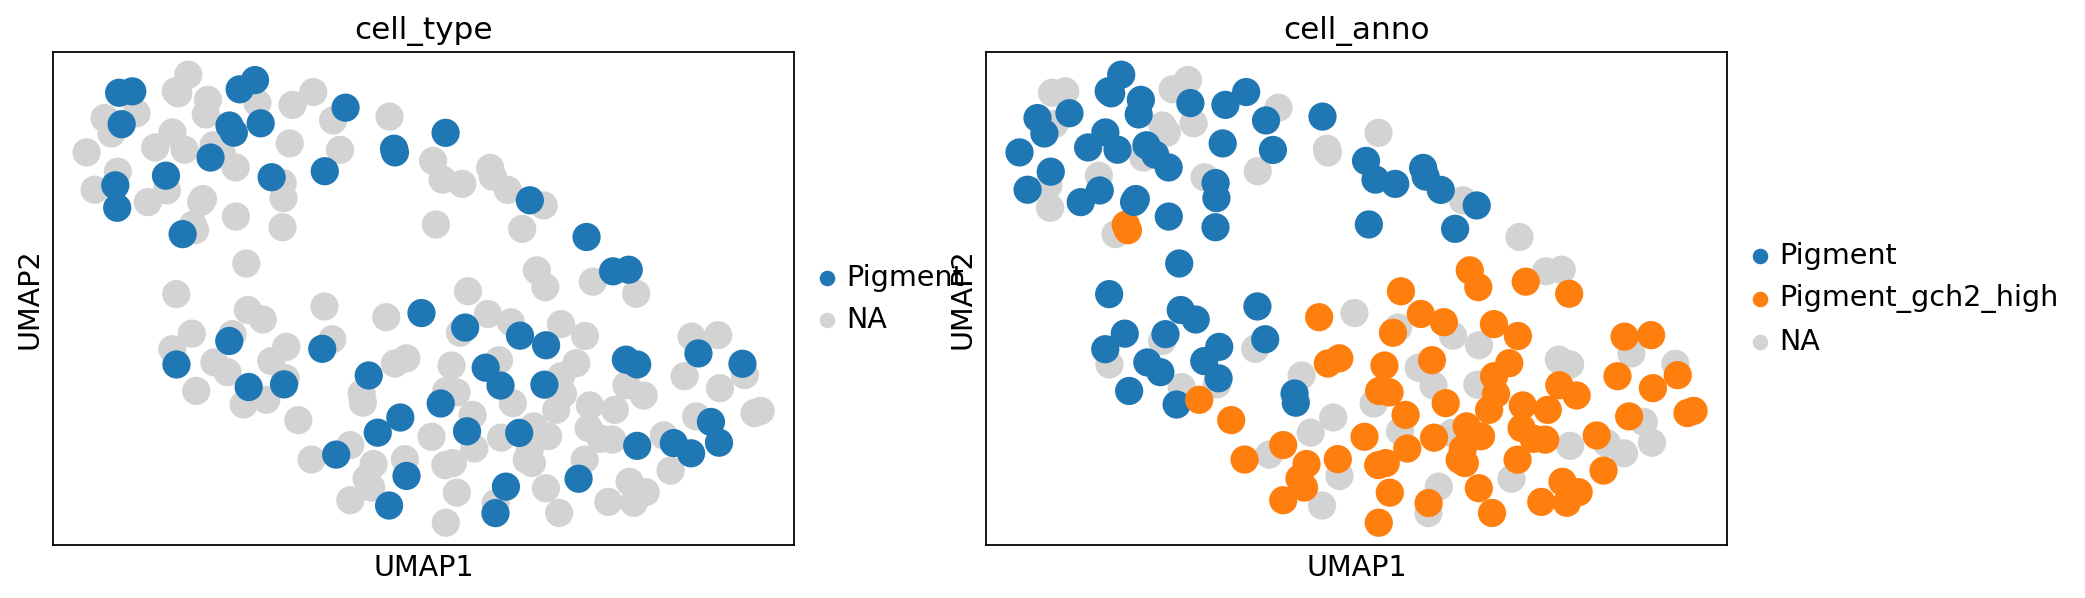

In [16]:
sc.pl.umap(
    merged_adata,
    color=["cell_type","cell_anno"],
    # Setting a smaller point size to get prevent overlap
)

In [17]:
X = merged_adata.obsm['X_pca_harmony'].astype('float32')

# build FAISS KNN index
n_cells = X.shape[0]
k = 10

index = faiss.IndexFlatL2(X.shape[1])
index.add(X)
distances, neighbors = index.search(X, k)

# project neighbors cell type label
sgRNA_labels = merged_adata.obs['cell_anno'].values
neighbor_labels = sgRNA_labels[neighbors]

In [18]:
mutant_mask = (neighbor_labels != 'control').astype(int)
mutant_neighbor_counts = mutant_mask.sum(axis=1)

In [19]:
score = (np.array(neighbor_labels[merged_adata.obs["cell_type"].isin(["Pigment"])]) == "Pigment_gch2_high").astype(int)
score = score.sum(axis = 1)/10

In [20]:
annotation = pd.DataFrame(merged_adata.obs["cell_type"][merged_adata.obs["cell_type"].isin(["Pigment"])])

In [22]:
annotation.loc[score >= 0.7,"pigment_annotation"] = "Pigment_gch2"

## Save data

In [23]:
if SAVE_DATA:
    annotation.to_csv(DATA_DIR / DATASET / "processed" / "annotation.csv")